In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

In [4]:
def plot_line(df, title):
    fig = px.line(df, x = 'date', y = 'count', title = title)
    fig.show()
    
def filter_column(df, column, border_low, border_high):
    filter_mask = (df[column] >= border_low) & (df[column] < border_high)
    
    filtered_df = df[filter_mask].reset_index(drop=True)
    return filtered_df

In [25]:
data = pd.read_csv("dataset/in_total.csv", thousands=r',', encoding='utf-8')

In [26]:
data

,date,count
0,2015-09-19,724
1,2015-09-20,907
2,2015-09-21,553
3,2015-09-22,796
4,2015-09-23,804
...,...,...
1889,2020-06-26,96150
1890,2020-06-27,107001
1891,2020-06-28,98568
1892,2020-06-29,70053


In [68]:
data['date'] = pd.to_datetime(data['date'])
data['count'] = pd.to_numeric(data['count'])

KeyError: 'date'

In [29]:
criterion_low = pd.Timestamp(2015, 9,19)
criterion_high = pd.Timestamp(2020, 1,1)

train_data = filter_column(data, 'date', criterion_low, criterion_high)

criterion_low = pd.Timestamp(2020, 1,1)
criterion_high = pd.Timestamp(2020, 6,30)

test_data = filter_column(data, 'date', criterion_low, criterion_high)

In [35]:
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

train_data['date'] = pd.to_datetime(train_data['date'])
train_data = train_data.set_index('date')

test_data['date'] = pd.to_datetime(test_data['date'])
test_data = test_data.set_index('date')

In [36]:
diff_train_data = train_data.copy()
diff_train_data1 = diff_train_data['count'].diff()
diff_train_data1 = diff_train_data1.dropna()
diff_train_data2 = diff_train_data1.diff()
diff_train_data2 = diff_train_data2.dropna()

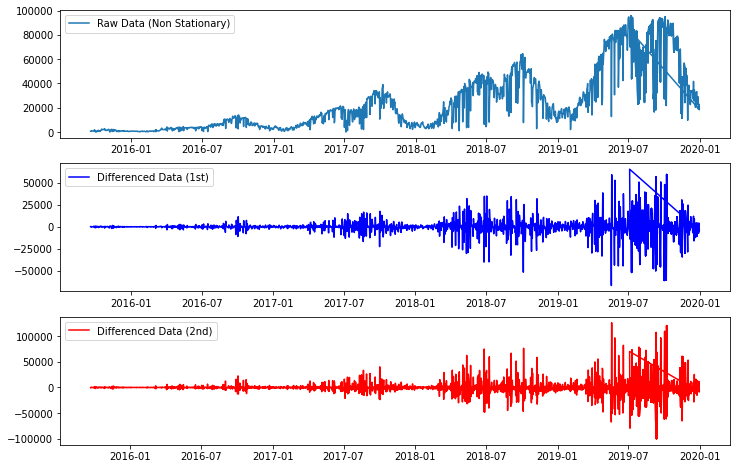

In [37]:
plt.figure(figsize = (12, 8))
plt.subplot(311)
plt.plot(train_data['count'])
plt.legend(['Raw Data (Non Stationary)'])
plt.subplot(312)
plt.plot(diff_train_data1, 'blue')
plt.legend(['Differenced Data (1st)'])
plt.subplot(313)
plt.plot(diff_train_data2, 'red')
plt.legend(['Differenced Data (2nd)'])
plt.show()

In [38]:
import statsmodels
from statsmodels.tsa.stattools import adfuller
import pandas as pd

class StationarityTests:
    def __init__(self, significance = .05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        
    def ADF_Stationarity_Test(self, timeseries, printResults = True):

        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])

            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value

            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)
            
# sTest = StationarityTests()
# sTest.ADF_Stationarity_Test(diff_train_data1, printResults = True)
# print("Is the time series stationary? {0}".format(sTest.isStationary))

for datum in [train_data, diff_train_data1, diff_train_data2]:
    sTest = StationarityTests()
    sTest.ADF_Stationarity_Test(datum, printResults = True)
    print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic        -1.782664
P-Value                    0.389102
# Lags Used               25.000000
# Observations Used     1686.000000
Critical Value (1%)       -3.434235
Critical Value (5%)       -2.863256
Critical Value (10%)      -2.567683
dtype: float64
Is the time series stationary? False
Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.131449e+01
P-Value                 1.216052e-20
# Lags Used             2.500000e+01
# Observations Used     1.685000e+03
Critical Value (1%)    -3.434237e+00
Critical Value (5%)    -2.863257e+00
Critical Value (10%)   -2.567684e+00
dtype: float64
Is the time series stationary? True
Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.750647e+01
P-Value                 4.357805e-30
# Lags Used             2.500000e+01
# Observations Used     1.684000e+03
Critical Value (1%)    -3.434239e+00
Critical Value (5%)    -2.863258e+00
Critical Value (10%)   -2.567685e+00
dtype: float6

In [39]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

arima_model = pm.arima.auto_arima(train_data, start_p=1, start_q=1,
                           max_p=2, max_q=2, m=12,
                           start_P=0, seasonal = False,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=False)
print(arima_model.aic())

/home/lee/.pyenv/versions/machine_learning/lib/python3.7/site-packages/pmdarima/arima/_validation.py:60: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36786.035, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=36313.377, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=36274.224, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=36559.477, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=36278.475, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=36275.791, Time=0.37 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=36414.572, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=36277.702, Time=0.26 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=36276.242, Time=0.41 sec
Total fit time: 2.125 seconds
36274.224133771844


In [60]:
arima_model.order

(0, 1, 2)

In [40]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

sarima_model = pm.arima.auto_arima(train_data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=False)
print(sarima_model.aic())

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=37774.319, Time=0.07 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=36587.491, Time=3.51 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=36586.612, Time=12.64 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=37307.026, Time=0.89 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=36693.351, Time=3.99 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=36665.828, Time=11.40 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=37093.341, Time=2.69 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=36663.737, Time=9.79 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=36654.664, Time=17.52 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=37386.835, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=36114.414, Time=8.15 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=36539.710, Time=10.68 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=36898.158, Time=2.00 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=36101.183, Time=11.44 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=

In [64]:
sarima_model.seasonal_order

(1, 1, 1, 12)

In [48]:
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey
from scipy.stats import probplot, shapiro, jarque_bera
from sklearn.metrics import r2_score

In [44]:
def model_diagnostics(residuals, model_obj):
    # For Breusch-Godfrey we have to pass the results object
#     godfrey = acorr_breusch_godfrey(model_obj, nlags= 30)
    ljung = acorr_ljungbox(residuals, lags= 30)
    shap = shapiro(residuals)
    j_bera = jarque_bera(residuals)
    print('Results of Ljung-Box:')
    print('Null Hypothesis: No auto-correlation')
    print('P-Value =< Alpha(.05) : Reject Null')
    print(f'p-values: {ljung[1]}\n')
#     print('Results of Breusch-Godfrey:')
#     print('Null Hypothesis: No auotcorrelation')
#     print('P-Value =< Alpha(.05) => Reject Null')   
#     print(f'p-values: {godfrey[1]}\n')
    print('Results of Shapiro-Wilks:')
    print('Null Hypothesis: Data is normally distributed')
    print('P-Value =< Alpha(.05) => Reject Null')   
    print(f'p-value: {shap[1]}\n')
    print('Results of Jarque-Bera:')
    print('Null Hypothesis: Data is normally distributed')
    print('P-Value =< Alpha(.05) => Reject Null')   
    print(f'p-value: {j_bera[1]}')

def plot_diagnostics(residuals):
#     px.line(residuals, title='ARIMA Residuals',)
#     residuals.plot(title='ARIMA Residuals', figsize=(15, 10))
#     plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    ax[0].set_title('ARIMA Residuals KDE')
    ax[1].set_title('ARIMA Resduals Probability Plot')    
    pd.Series(residuals).plot(kind='kde', ax=ax[0])
    probplot(residuals, dist='norm', plot=ax[1])
    plt.show()

/home/lee/.pyenv/versions/machine_learning/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


Results of Ljung-Box:
Null Hypothesis: No auto-correlation
P-Value =< Alpha(.05) : Reject Null
p-values: [9.43546215e-01 9.80493730e-01 9.83440650e-01 9.96837517e-01
 1.15466403e-01 1.19006032e-01 1.51664874e-01 2.10434160e-01
 9.64549748e-05 9.72709679e-05 7.23575305e-05 1.72130629e-06
 1.32625184e-08 2.94971503e-08 1.36683557e-09 1.26527040e-10
 2.74859300e-10 5.86380964e-10 8.12034650e-12 1.84574338e-11
 3.93085922e-11 8.03020637e-12 1.64571573e-11 3.47707211e-11
 1.87101336e-17 5.52932551e-18 5.16099594e-20 8.51530747e-20
 3.08616817e-21 7.44430882e-21]

Results of Shapiro-Wilks:
Null Hypothesis: Data is normally distributed
P-Value =< Alpha(.05) => Reject Null
p-value: 1.3312335411085762e-43

Results of Jarque-Bera:
Null Hypothesis: Data is normally distributed
P-Value =< Alpha(.05) => Reject Null
p-value: 0.0


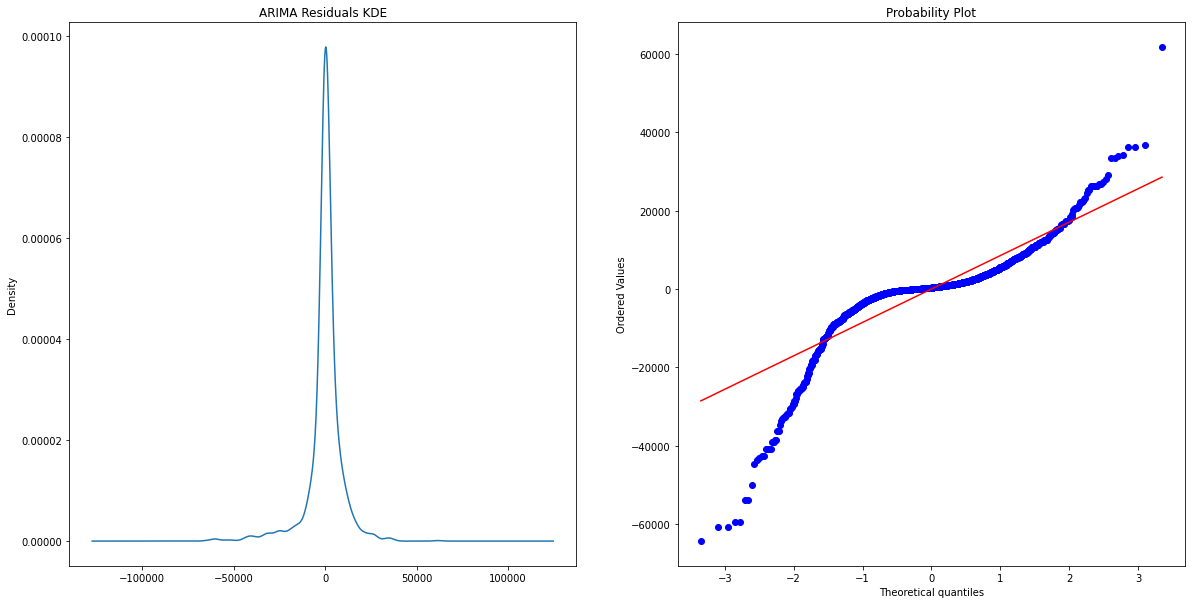

/home/lee/.pyenv/versions/machine_learning/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


Results of Ljung-Box:
Null Hypothesis: No auto-correlation
P-Value =< Alpha(.05) : Reject Null
p-values: [9.49390302e-01 9.64705064e-01 9.90790831e-01 9.96979722e-01
 1.02245617e-01 1.05581463e-01 1.38266018e-01 1.95343317e-01
 9.29302317e-05 7.85412093e-05 5.82837758e-05 1.14218762e-04
 3.16682460e-06 6.04131441e-06 1.11725368e-07 1.27834730e-08
 2.58586127e-08 5.20632853e-08 8.18384861e-10 1.71307084e-09
 3.54933109e-09 7.04344022e-10 1.44210314e-09 2.48843330e-09
 6.25210520e-15 1.56937028e-15 4.34558168e-18 6.77043709e-18
 3.42800753e-19 7.70477548e-19]

Results of Shapiro-Wilks:
Null Hypothesis: Data is normally distributed
P-Value =< Alpha(.05) => Reject Null
p-value: 1.877739942195255e-43

Results of Jarque-Bera:
Null Hypothesis: Data is normally distributed
P-Value =< Alpha(.05) => Reject Null
p-value: 0.0


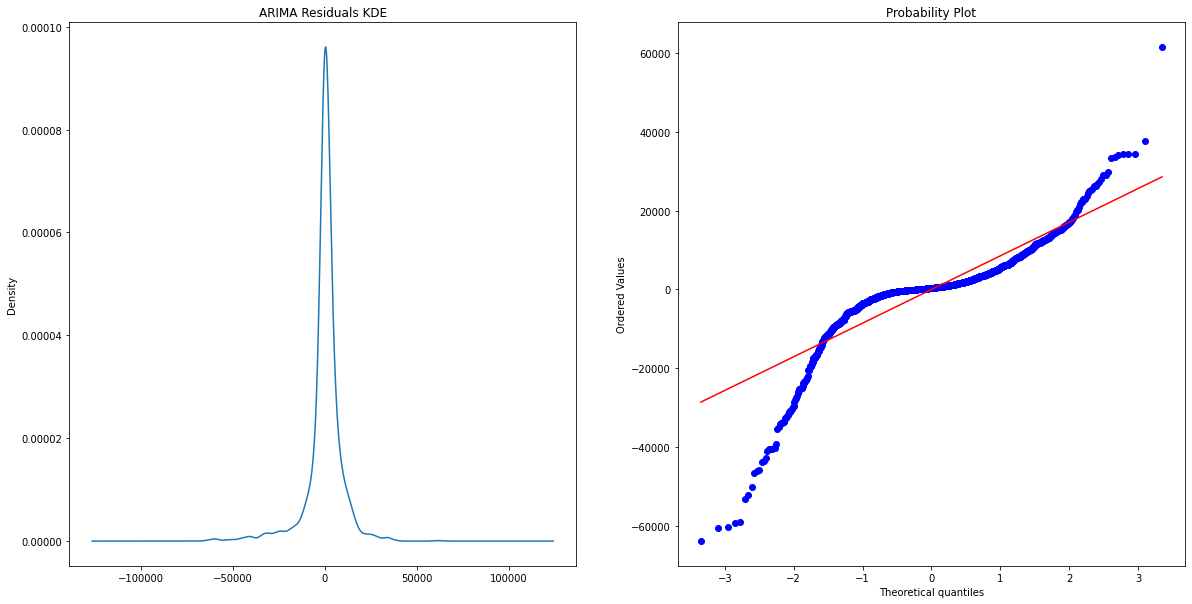

In [65]:
amodel_opt = ARIMA(train_data.values, order = arima_model.order)
amodel_opt_fit = amodel_opt.fit()
amodel_opt_fit.summary()

arima_resid = amodel_opt_fit.resid

model_diagnostics(arima_resid, amodel_opt_fit)
plot_diagnostics(arima_resid)

smodel_opt = SARIMAX(train_data.values, order = sarima_model.order, seasonal_order = sarima_model.seasonal_order)
smodel_opt_fit =smodel_opt.fit()
smodel_opt_fit.summary()

sarima_resid = smodel_opt_fit.resid

model_diagnostics(sarima_resid, smodel_opt_fit)
plot_diagnostics(sarima_resid)

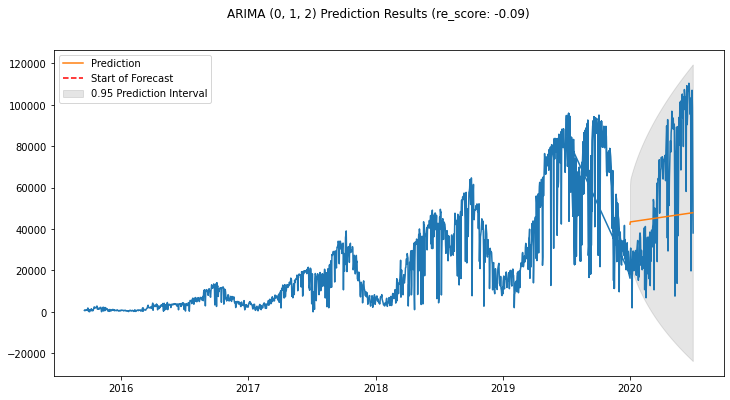

In [66]:
prediction = amodel_opt_fit.forecast(len(test_data))
predicted_value = prediction[0]
predicted_ub = prediction[2][:,0]
predicted_lb = prediction[2][:,1]
predict_index = list(test_data.index)

r2 = r2_score(test_data, predicted_value)

fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(data);

ax.vlines(test_data.index[0], 0, 125, linestyle='--', color = 'r', label ='Start of Forecast')
ax.plot(predict_index, predicted_value, label = 'Prediction')

ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label = '0.95 Prediction Interval')

ax.legend(loc = 'upper left')

plt.suptitle(f'ARIMA {arima_model.order} Prediction Results (re_score: {round(r2, 2)})')
plt.show()

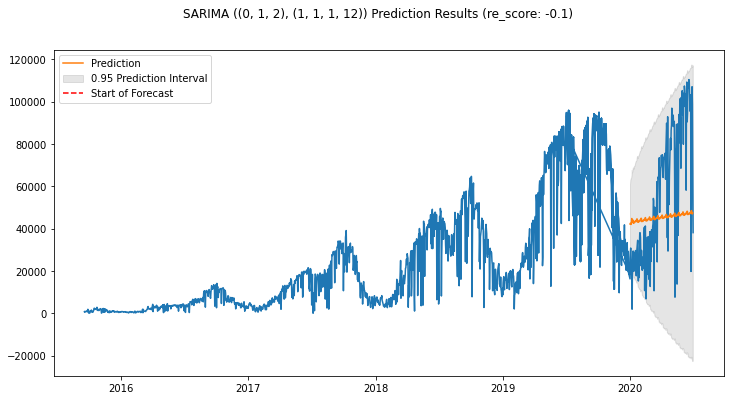

In [67]:
prediction = smodel_opt_fit.get_forecast(len(test_data))
predicted_value = prediction.predicted_mean
predicted_ub = prediction.conf_int()[:, 0]
predicted_lb = prediction.conf_int()[:, 1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(data)

ax.plot(predict_index, predicted_value, label = 'Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label = '0.95 Prediction Interval')
ax.vlines(test_data.index[0], 0,125, linestyle='--', color = 'r', label ='Start of Forecast')

ax.legend(loc = 'upper left')

plt.suptitle(f'SARIMA {sarima_model.order, sarima_model.seasonal_order} Prediction Results (re_score: {round(r2, 2)})')
plt.show()